# South America Simulations under Neutral and Niche Dynamics

Objective: 
1) Simulate South American diveristy whereby climate has no impact on population abundance
2) Simulate South American diversity whereby climate has an impact on population abundance

For simulations the speciation rate and death rate will be constant. Growth rate (r) will be the only parameter that varies between simulations.

In [1]:
import os
os.chdir('/Users/wyattpetryshen/Documents/GitHub/Metacommunity-Models-In-Python/main/python-functions')
# Import functions
#from MCME_Speciation import MCME
from MCME_Allopatric import MCME
import MCME_Functions
import MC_Properies_Functions
import numpy as np
from MCME_Plot_Functions import mcme_plot, species_richness_plot, plot_origination_extinction, plot_richness_map, get_richness
import MCME_Plot_Functions
import butterworth_filter
import matplotlib.pyplot as plt
import sys
import Climate_Import
import pandas as pd
import random
import math
import matplotlib

In [2]:
### General improvements for speed
# Convert distance matrix to off-diagonal (upper or lower triangle) only, or sparse-matrix
# Having a static-global distance matrix with a resistence matrix may be better
# Resistence matrix defined by habitat niche
### You need to work through an example with 1 starting species; can't just copy old interaction matrix's

#########################
#  Set Function Inputs  #
#########################
Tmax_4kyr = Climate_Import.import_climate_data("/Users/wyattpetryshen/Documents/Nature Paper 2024/Climate/Proc_Bricks/Tmax.mon.4kyr.tif", "Geotif", "rasterio")

Importing Raster file.
Import Complete


In [48]:
#########################
#   Global Parameters   #
#########################

S = 100 # set sarting species number
max_growth_r = 5 # set max growth rate
M = 165 # set patch number


In [49]:
###################################
#  Import Continental Coordinates #
###################################

# Metacommunity on North America
Cont_Coords = pd.read_csv("/Users/wyattpetryshen/Documents/GitHub/Metacommunity-Models-In-Python/main/World_Continent_Coords.csv")

# Extract only NA coords
# Keep these below lines for full dataset
mask = Cont_Coords.Cont == "South America"
Clim_array = Cont_Coords[mask].reset_index()

# Convert Data Frame into array of zip (lon,lat)
Clim_Coords = list()
for i in range(len(Clim_array)):
    Clim_Coords.append((Clim_array.Lon_d[i], Clim_array.Lat_d[i]))
    
# Randomly sample points in North America
coord_index = np.random.choice(range(len(Clim_array)), M, replace = False)
coords = [Clim_Coords[i] for i in coord_index]

# Define distance matrix
distance_matrix = MCME_Functions.get_graph_distance_matrix_HadCM3(coords)


In [50]:
###################################
#       Interpolate Climate       #
###################################
# Intervals: 4 kya, 50 kya, 100 kya
# Native resolution climate for desired coordinates
climate_4kya = Climate_Import.return_climate_array(coords, 400, 901, Tmax_4kyr) - 273.5

In [51]:
###################################
#    Set up Model Parameters      #
###################################
# Max Simulation time
sim_time = climate_4kya.shape[0]
# Simulation times
time_in = [200, 10, 100, sim_time] # seed time, seed inteval, burn-in time, simulation time
# Set intial species niche optimums; this will stay static between all simulations
niche_optimum_ini_4 = MCME_Functions.initial_species_niche_optimum(S, M, climate_4kya[0,:])

In [52]:
###################################
#     Iteratable Parameters       #
###################################
# Dispersal ability
#dispersal_rate_ini = MCME_Functions.random_dispersal_vector(16, 1e-5, 1)
dispersal_rate_ini = [0.01]
# Niche Breadth
niche_breadth = [2.5]
# narrow = 0.5
# wide = 2.5
# Specify the speciation rate
speciation_threshold = [0.25]
# Species interaction end-members
end_member = ["equal", "stabalizing", "mixed", "neutral"]
# Equal species interactions
alpha_matrix_equal = MCME_Functions.initalize_aij("equal", 0.0, 1.0, S, 0.3)
# Stabalizing species interactions
alpha_matrix_stabalizing = MCME_Functions.initalize_aij("stabalizing", 0.0, 0.5, S, 0.3)
# Mixed species interactions
alpha_matrix_mixed = MCME_Functions.initalize_aij("mixed", 0.0, 1.5, S, 0.3)
# Neutral species interactions
alpha_matrix_neutral = MCME_Functions.initalize_aij("neutral", 0.0, 1.0, S, 0.3)
alpha_matrix_list = list([alpha_matrix_equal, alpha_matrix_stabalizing, alpha_matrix_mixed, alpha_matrix_neutral])


In [53]:
#########################
#   Run Simulation Exp  #
#########################
# 4 kya forcings wide

# Very large values for niche breath effectively allows for climate to have no effect on growth rate

results, niche_opt, alpha_matrix, phylogeny, divergence_time, patch_origin = MCME(time_in =  [250, 10, 100, 500],
                                                                   species_number_ini = S,
                                                                   max_growth_r = 5,
                                                                   speciation_threshold = 0.25,
                                                                   alpha_matrix_ini = alpha_matrix_stabalizing,
                                                                   distance_matrix = distance_matrix,
                                                                   climate_input = climate_4kya,
                                                                   niche_optimum_ini = niche_optimum_ini_4,
                                                                   dispersal_rate_ini = 0.1,
                                                                   niche_breadth_ini = 1,
                                                                   end_member = "stabalizing")

250 Step Seeding Complete
350 Step Burn in Complete


100%|██████████| 500/500 [18:08<00:00,  2.18s/it]


Total Simulation Generations: 500


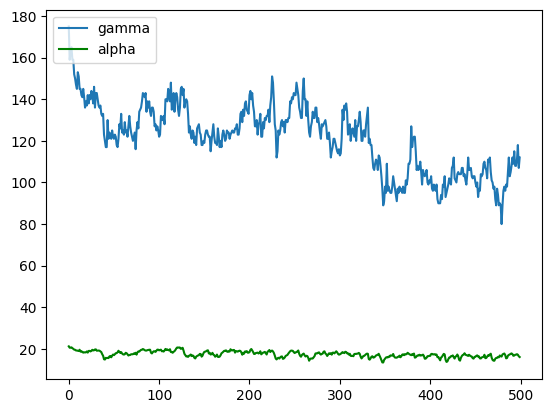

In [54]:
##########################
# Calculate Comm Metrics #
##########################
n_gamma = MC_Properies_Functions.gamma_diversity(results)
n_alpha = MC_Properies_Functions.alpha_richness(results)

# Plot of gamma and alpha diversity
x = np.arange(0,len(n_alpha))
plt.plot(x, n_gamma, label = "gamma")
plt.plot(x, n_alpha, c = "green", label = "alpha")
plt.legend(loc="upper left")

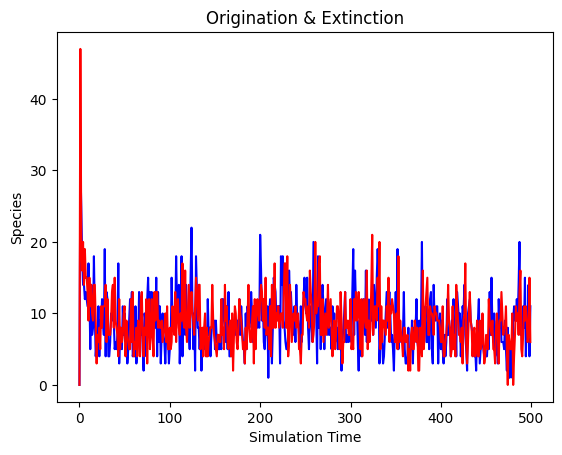

In [55]:
###################################
# Plot of species richness change #
###################################
orgination, extinction = plot_origination_extinction(results, True)

In [13]:
import os
os.chdir("/Users/wyattpetryshen/Documents/GitHub/Scaling-of-Biodiversity/src/")
from HaarFluctuationAnalysis import Haar_hebert, arns_haar_fluct
from non_equidistant_haar_import import Haar_RMS_fluctuations
from CrossHaarCorrelation import CCH, CHC

In [56]:
# Need mean climate 
climate_mean = np.mean(climate_4kya, axis = 1)

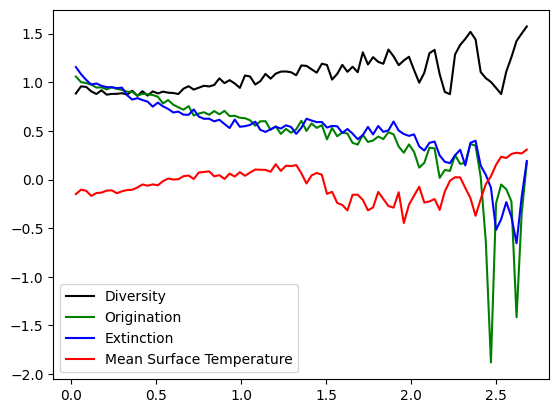

In [57]:
haar_simDiv, full_simDiv, _ = Haar_hebert(np.array(n_gamma), np.arange(0, len(n_gamma)), Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_simOri, full_simOri, _ = Haar_hebert(np.array(orgination[:,1]), np.arange(0, len(orgination)), Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_simExt, full_simExt, _ = Haar_hebert(np.array(extinction[:,1]), np.arange(0, len(extinction)), Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_simClim, full_simClim, _ = Haar_hebert(np.array(climate_mean[1:]), np.arange(0, len(climate_mean[1:])), Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)

plt.plot(np.log10(haar_simDiv[:, 0]), np.log10(haar_simDiv[:, 1]), c="black", linestyle = "solid", label = "Diversity")
plt.plot(np.log10(haar_simOri[:, 0]), np.log10(haar_simOri[:, 1]), c="green", linestyle = "solid", label = "Origination")
plt.plot(np.log10(haar_simExt[:, 0]), np.log10(haar_simExt[:, 1]), c="blue", linestyle = "solid", label = "Extinction")
plt.plot(np.log10(haar_simClim[:, 0]), np.log10(haar_simClim[:, 1]), c="red", linestyle = "solid", label = "Mean Surface Temperature")
plt.legend()

In [ ]:
# Patch diversity
# Create matrix to store results
def allPatchAlpha(untb_results):
    tmp = np.full(shape = (M, len(untb_results)), fill_value=np.nan)
    for t in range(len(untb_results)):
        for r in range(M):
            tmp[r, t] = np.sum(untb_results[t][r,:] != 0)
    return tmp

PatchDiversity = allPatchAlpha(results)

In [ ]:
# Extinction 
def extRateProp(input_dict):
    ext = np.full(len(input_dict), fill_value = 0, dtype=float)
    for i in np.arange(1, len(input_dict)):
        ext[i - 1] = np.size(np.setdiff1d(input_dict[i - 1], input_dict[i]))
    return ext

# Origination
def oriRateProp(input_dict):
    ori = np.full(len(input_dict), fill_value = 0, dtype=float)
    for i in np.arange(1, len(input_dict)):
        ori[i - 1] = np.size(np.setdiff1d(input_dict[i], input_dict[i - 1]))
    return ori

def allPatchExtOri(untb_results):
    tmp = np.full(shape = (M, len(untb_results)), fill_value=np.nan)
    return tmp

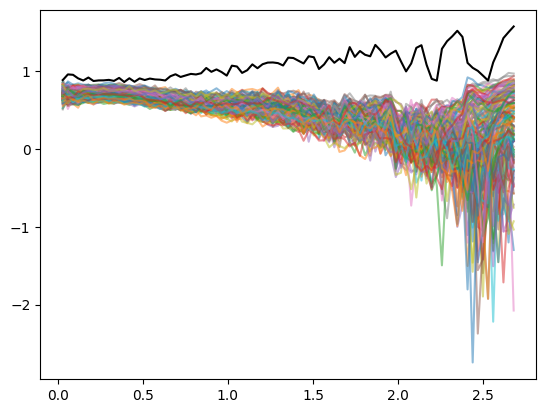

In [81]:
for i in range(165):
    haar_test_alpha, _, _ = Haar_hebert(tmp[i,:], np.arange(500), Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    plt.plot(np.log10(haar_test_alpha[:, 0]), np.log10(haar_test_alpha[:, 1]), alpha = 0.5)
plt.plot(np.log10(haar_simDiv[:, 0]), np.log10(haar_simDiv[:, 1]), c="black", linestyle = "solid", label = "Diversity")